# Plot model fits for simulation analysis 2

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from cfr import framework
from cfr import figures
from cfr import task

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'

data_file = res_dir / 'cfr_eeg_mixed.csv'
patterns_file = res_dir / 'cfr_patterns.hdf5'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

/Users/morton/miniconda3/envs/cfr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/morton/miniconda3/envs/cfr/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
models = [
    'cmrs_fcf-loc-cat-use',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_enc_cat1-B_enc_use1-B_rec_cat1-B_rec_use1',
    'cmrs_fcf-loc_ff-cat-use',
]
model_names = [
    'DCMR',
    'DCMR-Variable',
    'DCMR-Restricted',
    'DCMR-NoSemDrift',
    'CMR-MP16',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.3494320779585509, 0.6179457692495821, 0.5097488287111857),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.21624286340091695, 0.4448723771080803, 0.44657182426748937),
 (0.1705121585885322, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.6078198204764038, 0.8100431115060979, 0.6886397639333763),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.4070747349353, 0.652426424100314, 0.636598258552902),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.8450211160547234, 0.9362872108083329, 0.8814962450073144),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.7354447959037446, 0.8755917381696569, 0.8665505572807145),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [9]:
drw = data.groupby('source').apply(
    fr.distance_rank_window, 
    'item_index', 
    1 - rsm, 
    np.array([-1, 0, 1]),
    test_key='category', 
    test=lambda x, y: x == y,
)

In [15]:
neg = drw.reset_index(0).query("lag == -1").set_index(["source", "subject"]).drop(columns="lag")
pos = drw.reset_index(0).query("lag == 1").set_index(["source", "subject"]).drop(columns="lag")
diff = pos - neg

LINO NOT subset; don't know how to subset; dropped


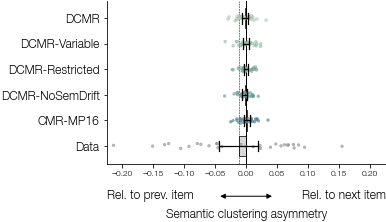

In [45]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    diff,
    x='rank',
    y='source',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='large')
ax.axvline(0, *ax.get_ylim(), linewidth=1, color='k')
ax.set(
    ylabel="", 
    xlabel="Semantic clustering asymmetry", 
    xlim=(-0.225, 0.225), 
)

# add annotation to help with interpretation
prop = dict(
    rotation='horizontal', 
    xycoords='axes fraction',
    verticalalignment='center',
    fontsize='large',
)
yoffset = -0.2
xoffset = 0.1
ax.annotate(
    'Rel. to prev. item', 
    xy=(0, yoffset), 
    horizontalalignment='left',
    **prop,
)
ax.annotate(
    'Rel. to next item', 
    xy=(1, yoffset), 
    horizontalalignment='right',
    **prop,
)
ax.annotate(
    '', 
    xy=(0.5 - xoffset, yoffset), 
    xytext=(0.5 + xoffset, yoffset), 
    arrowprops=dict(arrowstyle="<|-|>", facecolor='k'),
    xycoords='axes fraction',
)

ax.xaxis.set_label_coords(0.5, -0.28)
m = diff.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
None
fig.savefig(fig_dir / "dist_rank_asym.pdf")

LINO NOT subset; don't know how to subset; dropped


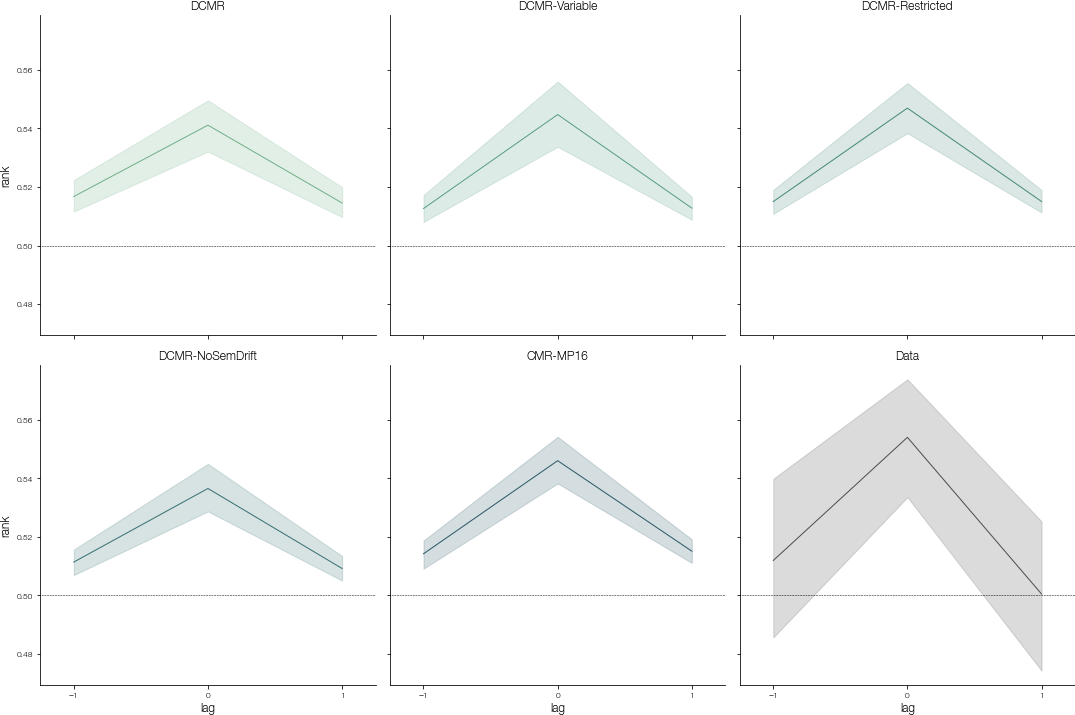

In [12]:
g = sns.relplot(
    data=drw, 
    x="lag", 
    y="rank", 
    col="source", 
    hue="source", 
    kind="line", 
    palette=curve,
    col_wrap=3,
    legend=False,
)
g.set_titles('{col_name}')
g.set(xticks=(-1, 0, 1), xlim=(-1.25, 1.25))
for ax in g.axes.flatten():
    ax.axhline(0.5, *ax.get_xlim(), linestyle="--", linewidth=.5, color='k')
fig.savefig(fig_dir / "dist_rank_window.pdf")

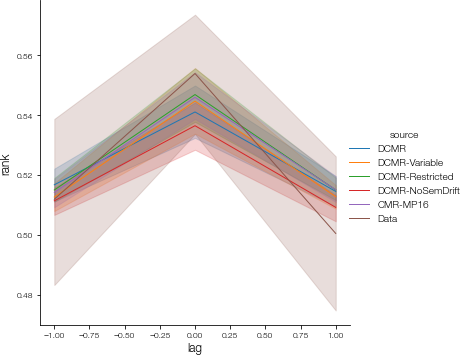

In [13]:
sns.relplot(data=drw, x="lag", y="rank", hue="source", kind="line")

In [17]:
p = diff.unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

rank                                                \
                 CMR-MP16          DCMR DCMR-NoSemDrift DCMR-Restricted   
T                0.358117     -0.891144       -1.088001        0.015549   
dof                    28            28              28              28   
alternative     two-sided     two-sided       two-sided       two-sided   
p-val            0.722941      0.380446        0.285872        0.987705   
CI95%        [-0.0, 0.01]  [-0.01, 0.0]    [-0.01, 0.0]     [-0.0, 0.0]   
cohen-d          0.066501      0.165481        0.202037        0.002887   
BF10                0.209         0.284           0.338           0.197   
power            0.063824      0.138257        0.182977        0.050026   

                                          
            DCMR-Variable           Data  
T                0.055129      -0.705926  
dof                    28             28  
alternative     two-sided      two-sided  
p-val            0.956427       0.486067  
CI95%        [-0.0, 0.01]  [-0.04, 0.02]  
cohen-d          0.010237       0.131087  
BF10                0.198          0.248  
power            0.050325       0.104749

## Serial position effects

In [18]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


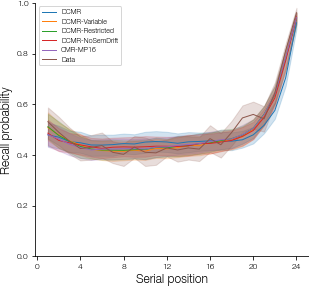

In [19]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.set(xticks=[0, 4, 8, 12, 16, 20, 24])
g.axes[0, 0].legend(fontsize='x-small')
g.savefig(fig_dir / 'spc_comp.pdf')

In [20]:
pnr = data.groupby('source').apply(fr.pnr)

LINO NOT subset; don't know how to subset; dropped


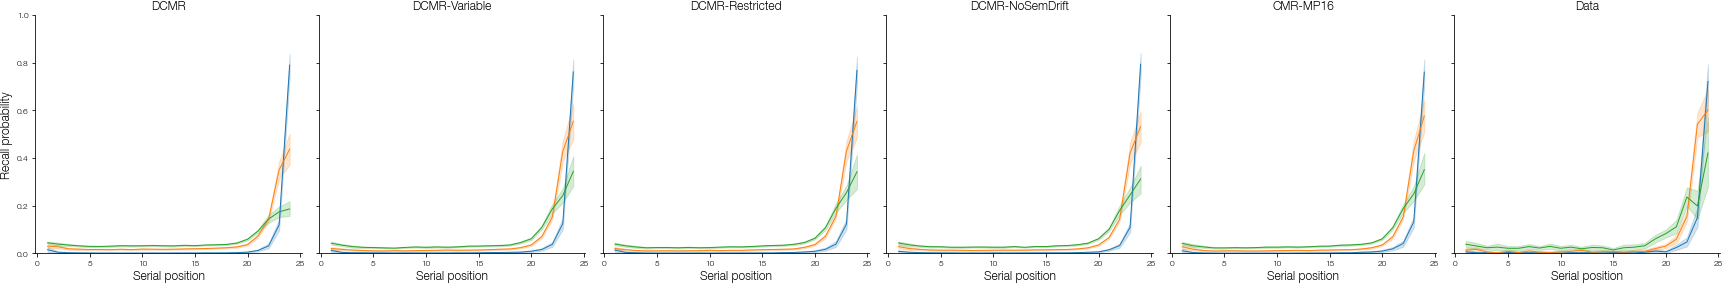

In [21]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='output', col='source', height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

## Clustering measures

In [22]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

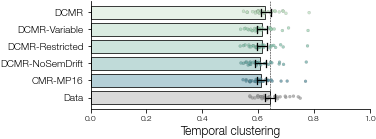

In [23]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [24]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

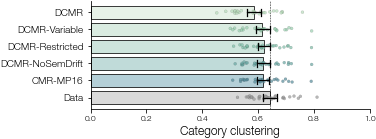

In [25]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    cat_crp,
    y='source',
    x='prob',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = cat_crp.loc['Data', 'prob'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Category clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_cat_crp.pdf')

In [26]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

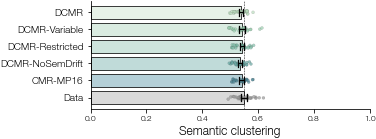

In [27]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    use_rank,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [28]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
    test_key='category', 
    test=lambda x, y: x == y,
)

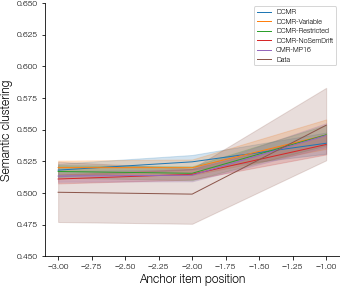

In [29]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
# g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [30]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.086707,56,two-sided,0.931213,"[-0.04, 0.03]",0.02277,0.267,0.050833


In [31]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.66365,56,two-sided,0.101769,"[-0.0, 0.01]",0.436896,0.837,0.372816


In [32]:
subs = dist_rank.loc['DCMR-Restricted']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.389629,56,two-sided,0.698289,"[-0.01, 0.01]",0.102321,0.284,0.066967


## Compound lag-CRP

In [33]:
crp = data.groupby('source').apply(
    fr.lag_crp_compound, test_key='category', test=lambda x, y: x == y
)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

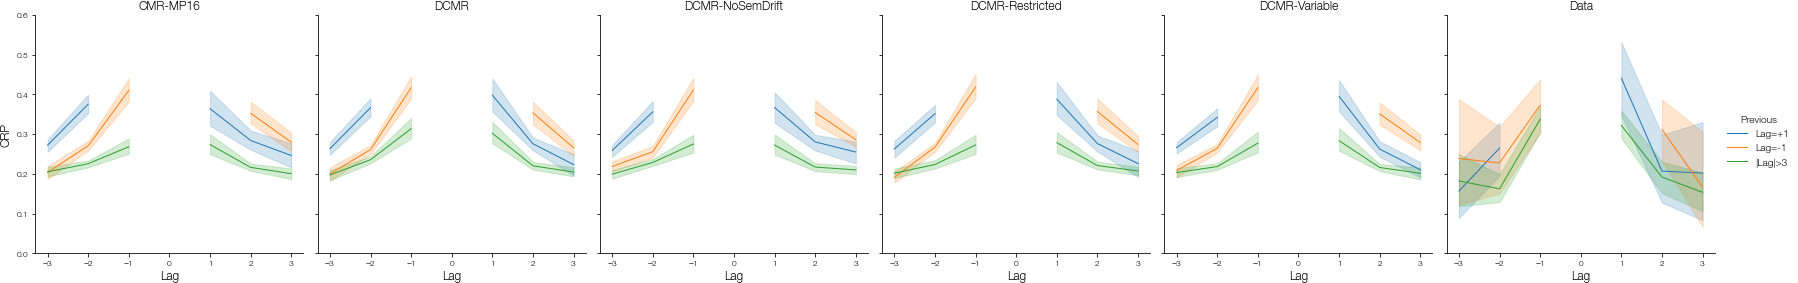

In [34]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
# g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [35]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.274438,27,two-sided,0.031101,"[0.01, 0.23]",0.429828,1.798,0.592181


In [36]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.937131,28,two-sided,0.356705,"[-0.04, 0.11]",0.174021,0.295,0.147867


### Test for compound cuing in DCMR-Restricted

In [37]:
subs = summed.loc['DCMR-Restricted']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.357047,28,two-sided,4.411672e-11,"[0.09, 0.13]",1.923255,2.165e+08,1.0


In [38]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.968954,28,two-sided,3.818579e-14,"[0.12, 0.17]",2.59397,1.778e+11,1.0


In [39]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.13.0

pandas    : 1.2.3
matplotlib: 3.5.2
psifr     : 0.9.0
mindstorm : 0.9.0
numpy     : 1.20.2
cymr      : 0.11.2
pingouin  : 0.5.2
cfr       : 0.1.0
seaborn   : 0.11.1

